In [15]:
#importing the neccessry libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# Imbalanced learning method used
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
RANDOM_STATE = 42

In [16]:
# load the dataset and view the header
df = pd.read_csv("creditcard.csv")

print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
class_counts = df['Class'].value_counts().sort_index()
fraud_rate = class_counts[1] / class_counts.sum()
print("Class counts:\n", class_counts)
print(f"\nFraud rate: {fraud_rate:.6f} (~{fraud_rate*100:.4f}%)")


Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64

Fraud rate: 0.001727 (~0.1727%)


In [7]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


((227845, 30),
 (56962, 30),
 Class
 0    0.998271
 1    0.001729
 Name: proportion, dtype: float64,
 Class
 0    0.99828
 1    0.00172
 Name: proportion, dtype: float64)

In [8]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    # Fit
    model.fit(X_tr, y_tr)
    # Predict
    y_pred = model.predict(X_te)

    # Report
    print(f"=== {name}: Classification Report (Test) ===")
    print(classification_report(y_te, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f"{name} — Confusion Matrix (Test)")
    plt.show()

    return model


=== Random Forest + SMOTE: Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.9998    0.9997    0.9998     56864
           1     0.8431    0.8776    0.8600        98

    accuracy                         0.9995     56962
   macro avg     0.9215    0.9386    0.9299     56962
weighted avg     0.9995    0.9995    0.9995     56962



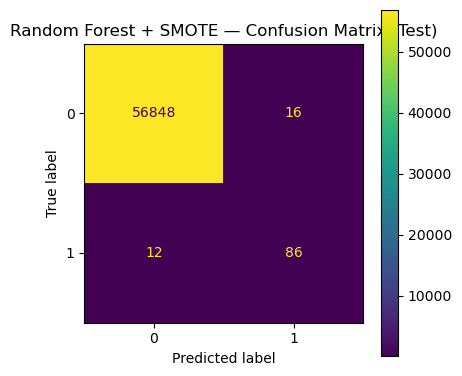

In [9]:
rf_pipeline = Pipeline(steps=[
    # SMOTE applies on the scaled/feature space; for RF we can skip scaling to keep trees natural
    ('smote', SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.2)),  # minority becomes 20% of majority (tune as needed)
    ('clf', RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

rf_model = evaluate_model("Random Forest + SMOTE", rf_pipeline, X_train, y_train, X_test, y_test)


=== XGBoost + SMOTE: Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8300    0.8469    0.8384        98

    accuracy                         0.9994     56962
   macro avg     0.9149    0.9233    0.9191     56962
weighted avg     0.9994    0.9994    0.9994     56962



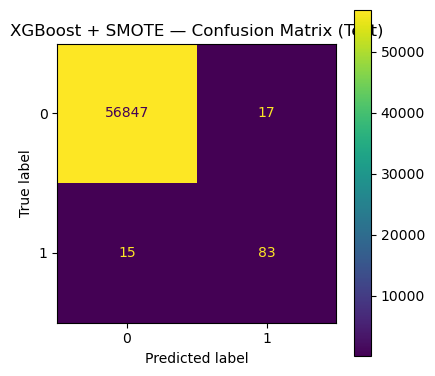

In [13]:
if XGB_AVAILABLE:
    xgb_pipeline = Pipeline(steps=[
        ('smote', SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.2)),
        ('clf', XGBClassifier(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss',
            tree_method='hist',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

    xgb_model = evaluate_model("XGBoost + SMOTE", xgb_pipeline, X_train, y_train, X_test, y_test)
else:
    print("xgboost not installed — skip this cell or install with: pip install xgboost")


=== SVM (RBF) + RobustScaler + SMOTE: Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.9998    0.9977    0.9987     56864
           1     0.3907    0.8571    0.5367        98

    accuracy                         0.9975     56962
   macro avg     0.6952    0.9274    0.7677     56962
weighted avg     0.9987    0.9975    0.9979     56962



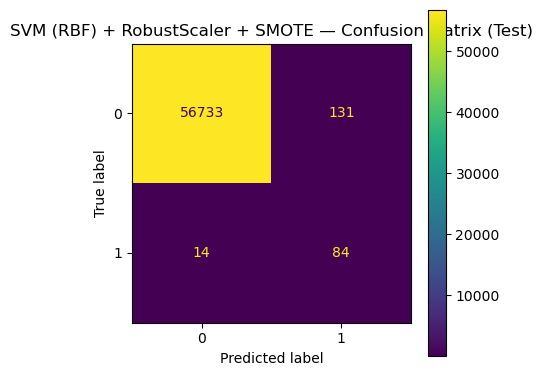

In [11]:
svm_pipeline = Pipeline(steps=[
    ('scaler', RobustScaler()),                         # scale first so SMOTE distances are meaningful
    ('smote', SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.2)),
    ('clf', SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, random_state=RANDOM_STATE))
])

svm_model = evaluate_model("SVM (RBF) + RobustScaler + SMOTE", svm_pipeline, X_train, y_train, X_test, y_test)


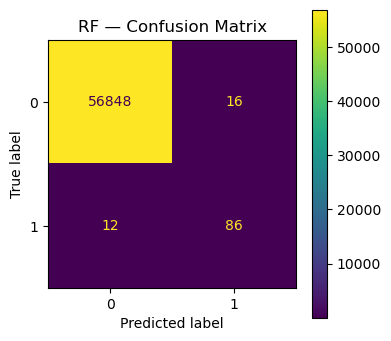

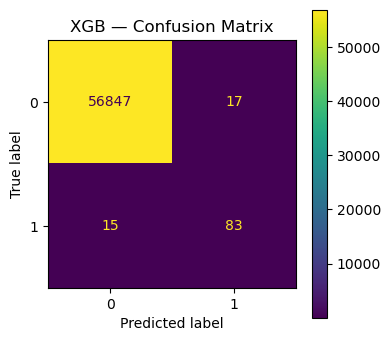

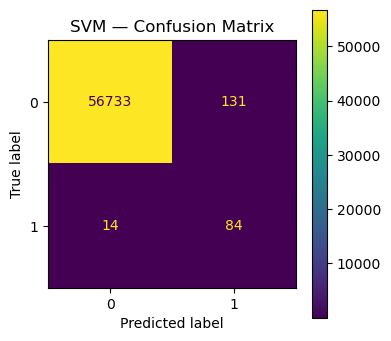

In [14]:
# Re-run predictions for a compact comparison view (optional)
def get_cm(model, X_te, y_te):
    y_pred = model.predict(X_te)
    return confusion_matrix(y_te, y_pred, labels=[0,1])

cms = []
labels = []

# Random Forest
labels.append("RF")
cms.append(get_cm(rf_model, X_test, y_test))

# XGBoost (if available)
if XGB_AVAILABLE:
    labels.append("XGB")
    cms.append(get_cm(xgb_model, X_test, y_test))

# SVM
labels.append("SVM")
cms.append(get_cm(svm_model, X_test, y_test))

# Plot
for lab, cm in zip(labels, cms):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.0, 4.0))
    disp.plot(ax=ax, values_format='d')
    ax.set_title(f"{lab} — Confusion Matrix")
    plt.show()
